## The problem

- Walking around in a 2D maze, with walls put in random locations

NOTE FOR COURSE:

randomness at constructor vs. randomness at `reset()`

e.g. frozen lake is random at constructor, so the task learns a random lake, but it's the same lake every reset

In [1]:
import gym
from gym.spaces import Discrete
import numpy as np
import ray
from ray.rllib.agents.dqn import DQNTrainer
from ray.rllib.agents.ppo import PPOTrainer
from ray.rllib.models.preprocessors import get_preprocessor 
import matplotlib.pyplot as plt
import copy

In [2]:
import torch

In [3]:
action_names = {
    0 : "up",
    1 : "down",
    2 : "left",
    3 : "right"
}

In [4]:
ray.init(ignore_reinit_error=True)

{'node_ip_address': '127.0.0.1',
 'raylet_ip_address': '127.0.0.1',
 'redis_address': None,
 'object_store_address': '/tmp/ray/session_2022-04-07_11-19-30_525881_2690/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2022-04-07_11-19-30_525881_2690/sockets/raylet',
 'webui_url': None,
 'session_dir': '/tmp/ray/session_2022-04-07_11-19-30_525881_2690',
 'metrics_export_port': 64052,
 'gcs_address': '127.0.0.1:52781',
 'address': '127.0.0.1:52781',
 'node_id': '63c21be23ad054a8aaab9327917d007f9e6500c439ba7bb81eb5f541'}

In [5]:
class RandomMazeEnvironment(gym.Env): 
    def __init__(self, env_config):
        self.ylen = env_config.get("ylen", 5)
        self.xlen = env_config.get("xlen", 5)
        
        self.action_space = gym.spaces.Discrete(4)
        
        # show entire state, not just nearby the player
        # self.observation_space = gym.spaces.Dict({
        #     "player" : gym.spaces.Discrete(self.ylen*self.xlen),
        #     "walls" : gym.spaces.MultiBinary(self.ylen*self.xlen)
        # })
        # self.observation_space = gym.spaces.MultiBinary([2, self.ylen, self.xlen])

        # see https://docs.ray.io/en/latest/rllib/rllib-models.html
        # looks like they mainly just preprocess discrete/multidiscrete and atari?
        # what about box?? hmm. i guess those go without preproc?
        
        self.observation_space = gym.spaces.MultiDiscrete([2,2,2,2])
        # self.observation_space = gym.spaces.Tuple([Discrete(2), Discrete(2), Discrete(2), Discrete(2)])
        # self.observation_space = gym.spaces.MultiBinary(4)
        
        self.seed = env_config.get("random_seed", None)
    
    def reset(self, seed=None):
        # print("RESET")
        self.player = (0, 0)
        self.exit = (self.ylen-1, self.xlen-1)
        
        if self.seed is not None: # fixed seed every time, not random maze
            np.random.seed(self.seed)
        
        self.walls = np.random.rand(self.ylen, self.xlen) < 0.2
        self.walls[self.player] = 0
        self.walls[self.exit] = 0
        
        self.num_steps = 0
        return self.get_observation()
    
    def get_observation(self): # SWAPPED FROM THE ABOVE ONE
        # make the observation into the entire state??
        # playerstate = self.player[1] + self.xlen*self.player[0]
        # obsdict = {
        #     "player" : playerstate,
        #     "walls" : self.wallsstate
        # }
        # return obsdict
        
        # playerstate = 0*self.walls
        # playerstate[self.player] = 1
        # return np.concatenate((playerstate[None], 
        #                        self.walls[None]), axis=0).astype(int)
        i, j = self.player

        obs = []
        obs.append(1 if i==0           else self.walls[i-1,j]) # up
        obs.append(1 if i==self.ylen-1 else self.walls[i+1,j]) # down
        obs.append(1 if j==0           else self.walls[i,j-1]) # left
        obs.append(1 if j==self.xlen-1 else self.walls[i,j+1]) # right
        return np.array(obs, dtype=int)
        # 3x3 context, 8 observations
        # wallsexit = self.walls.copy()
        # wallspad = np.pad(wallsexit, 1, constant_values=1) # pad with 1 to simulate walls all around
        # nearby = wallspad[self.player[0]:self.player[0]+3, self.player[1]:self.player[1]+3]
        # nearbyflat = nearby.flatten()
        # minus_middle = np.concatenate((nearbyflat[:4], nearbyflat[5:]))
        # return minus_middle
        # NW N NE W E SW S SE
    
    def step(self, action):
        self.num_steps += 1
        
        if action == 0: # move up
            new_loc = (self.player[0]-1, self.player[1])
            
        elif action == 1: # move down
            new_loc = (self.player[0]+1, self.player[1])
                
        elif action == 2: # move left
            new_loc = (self.player[0], self.player[1]-1)
  
        elif action == 3: # move right
            new_loc = (self.player[0], self.player[1]+1)
                
        else:
            raise Exception("Action must be {0,1,2,3}")
            
        # update state if you are able to move
        move_success = False
        if 0 <= new_loc[0] < self.ylen and 0 <= new_loc[1] < self.xlen and not self.walls[new_loc]:
            self.player = new_loc
            move_success = True
                
        info = {"player pos" : self.player}
        
        # reward
        distance = np.abs(self.player[0]-self.exit[0]) + np.abs(self.player[1]-self.exit[1])
        reward = -distance
        
        # penalize walking into walls
        if not move_success:
            reward -= 5
        
        return self.get_observation(), reward, self.is_done(), info

    
    def is_done(self):
        return self.player == self.exit or self.num_steps >= 500

    def render(self):
        for i in range(self.xlen):
            for j in range(self.ylen):
                if (i,j) == self.exit:
                    print("E", end="")
                elif (i,j) == self.player:
                    print("P", end="")
                elif self.walls[i,j]:
                    print("X", end="")
                else:
                    print(".", end="")
                # print("O", end="")
            print()

In [6]:
rme = RandomMazeEnvironment({})

In [7]:
rme.reset()

array([1, 0, 1, 0])

In [8]:
rme.render()

P....
..X..
X....
X...X
....E


In [9]:
rme.step(0)

(array([1, 0, 1, 0]), -13, False, {'player pos': (0, 0)})

In [10]:
# trainer_config_2 = copy.copy(trainer_config)
# trainer_config_2["model"] = {"fcnet_hiddens" : [64, 64]}

In [11]:
trainer_config_rme = {
    # "num_workers": 0,
    "model": {
        "fcnet_hiddens": [64, 64],
        "fcnet_activation": "relu",
    },
    "evaluation_num_workers": 1,
    # "create_env_on_driver" : True,
    "log_level" : "ERROR",
    "framework" : "torch"
    # "_disable_preprocessor_api" : True
    # "vf_loss_coef" : 1/20_000 # make this small if the value function loss is big, only if vf_share_layers
}

In [12]:
trainer = PPOTrainer(trainer_config_rme, env=RandomMazeEnvironment)

2022-04-07 11:19:33,012	WARNING trainer.py:2347 -- You have specified 1 evaluation workers, but your `evaluation_interval` is None! Therefore, evaluation will not occur automatically with each call to `Trainer.train()`. Instead, you will have to call `Trainer.evaluate()` manually in order to trigger an evaluation run.
2022-04-07 11:19:33,013	INFO ppo.py:249 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
2022-04-07 11:19:33,014	INFO trainer.py:779 -- Current log_level is ERROR. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
2022-04-07 11:19:34,150	WARNING util.py:55 -- Install gputil for GPU system monitoring.


In [13]:
trainer.config["train_batch_size"]

4000

This is measure in individual time steps, per worker.

In [14]:
rewards = []

In [15]:
for iteration in range(30):
    print(iteration)
    out = trainer.train();
    rewards.append(out['episode_reward_mean'])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


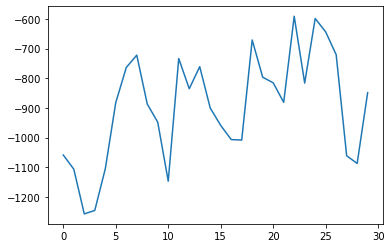

In [16]:
plt.plot(rewards);

In [17]:
len(out["hist_stats"]["episode_reward"])

100

^ number of episodes in one call to `trainer.train()`

Keeping the last 100 in memory for a moving average.

In [18]:
trainer.evaluate()

{'evaluation': {'episode_reward_max': -28.0,
  'episode_reward_min': -146.0,
  'episode_reward_mean': -61.4,
  'episode_len_mean': 14.3,
  'episode_media': {},
  'episodes_this_iter': 10,
  'policy_reward_min': {},
  'policy_reward_max': {},
  'policy_reward_mean': {},
  'custom_metrics': {},
  'hist_stats': {'episode_reward': [-78.0,
    -28.0,
    -90.0,
    -146.0,
    -44.0,
    -41.0,
    -65.0,
    -44.0,
    -28.0,
    -50.0],
   'episode_lengths': [20, 8, 16, 31, 13, 9, 13, 13, 8, 12]},
  'sampler_perf': {'mean_raw_obs_processing_ms': 0.07109675142500135,
   'mean_inference_ms': 0.2857082419925266,
   'mean_action_processing_ms': 0.016954210069444444,
   'mean_env_wait_ms': 0.020677844683329262,
   'mean_env_render_ms': 0.0},
  'off_policy_estimator': {},
  'timesteps_this_iter': 0}}

In [19]:
rme = RandomMazeEnvironment({})
obs = rme.reset() 
rme.render()

PX...
X..X.
..XX.
X..X.
X...E


In [20]:
action = trainer.compute_single_action(input_dict={"obs": obs})#, explore=False)
res = rme.step(action)
obs = res[0]
rme.render()

print("\naction:", action_names[action])
print("reward:", res[1])
print("done:", res[2])
print("obs:", obs)

PX...
X..X.
..XX.
X..X.
X...E

action: down
reward: -13
done: False
obs: [1 1 1 1]


In [21]:
from ipywidgets import Output
from IPython import display
import time

out = Output()
display.display(out)

with out:
    out.clear_output(wait=True)
    time.sleep(0.08)
    rme.render()

PX...
X..X.
..XX.
X..X.
X...E


In [22]:
policy = trainer.get_policy()
model = policy.model

In [23]:
# model_output = model({"obs": torch.from_numpy(obs)})[0]

In [24]:
# model_output

In [25]:
print(model)

FullyConnectedNetwork(
  (_logits): SlimFC(
    (_model): Sequential(
      (0): Linear(in_features=64, out_features=4, bias=True)
    )
  )
  (_hidden_layers): Sequential(
    (0): SlimFC(
      (_model): Sequential(
        (0): Linear(in_features=8, out_features=64, bias=True)
        (1): ReLU()
      )
    )
    (1): SlimFC(
      (_model): Sequential(
        (0): Linear(in_features=64, out_features=64, bias=True)
        (1): ReLU()
      )
    )
  )
  (_value_branch_separate): Sequential(
    (0): SlimFC(
      (_model): Sequential(
        (0): Linear(in_features=8, out_features=64, bias=True)
        (1): ReLU()
      )
    )
    (1): SlimFC(
      (_model): Sequential(
        (0): Linear(in_features=64, out_features=64, bias=True)
        (1): ReLU()
      )
    )
  )
  (_value_branch): SlimFC(
    (_model): Sequential(
      (0): Linear(in_features=64, out_features=1, bias=True)
    )
  )
)


In [26]:
list(trainer.get_policy().get_weights().values())[0].shape

(4, 64)

In [27]:
# q_values = model.get_q_value_distributions(model_output)

In [28]:
# q_values

In [29]:
dist = policy.dist_class(model_output, model) 
dist

NameError: name 'model_output' is not defined

In [ ]:
dist.sample()

In [ ]:
dist.dist

## Questions for Sven

- How many episodes are actually getting run during training/evaluation? Only 10?
  - It's complicated for training, but the batch size is measured in time steps (rather than episodes) so it also depends on episode length
- `compute_action` vs `compute_single_action` 
  - Use `compute_single_action`
- Can we go through the results of `print(model)` and understand why it looks the way it does?
  - for Pytorch specifically, the layers are shown alphabetically and not in order (it only gets linked up in the call to `forward`)
- How to get q values from `ComplexInputNetwork`?
  - Don't use `ComplexInputNetwork`, avoid at all costs
- What happens if you don't call `ray.init()` - the code still seems to run?
- DQN vs PPO
  - DQN more interpretable if you dig into the model, PPO more complicated.
  - PPO learns action probabilities, will sample from this distribution by default
- Is it fine to call `ray.init(ignore_reinit_error=True)` repeatedly?
  - Yes
- Why does `episode_reward_mean` not get better with more iterations? Is it because we've reaching the "ceiling" given the environment/model?
  - Wasn't working at all with `MultiBinary`
- What would be your next step to improve performance here? Ideas...
  - Reward crafting
  - Observation crafting
  - Model/algo tuning / ray tune
  - More iterations (how do you decide this? look for a plateau? results are generally quite noisy, I guess due to the randomness in the env)
  - ...?
- Higher-level question: in my google doc I have a list of envs for the tuned examples - which ones would be good for the course? can they be rendered?
- Can I reuse recsim material from Sven's tutorial in the course? (And if so, do we think it's a good idea)
- Ok to do the whole course with the Python API instead of the CLI?
- If we actually wanted to make a maze-winning AI, would we want to consider somehow giving it access to the same maze multiple times and not resetting EVERY time? Would that be advantageous for learning somehow? Or is it fine to randomize at every `reset`?
- In terms of the return of `step`, namely observation, reward, `is_done`, info -- is it correct that info is never used by any algorithm?
- What if we want the reward to be part of the observation?
- Is there a way to set a `random_state` in RLlib so that it performs the same actions every time?

Things that seem to have magically fixed themselves:

- Why does it say episode lengths are always 500 when it clearly seems to work (below)?
- When I do `dist.sample()`, why do I get numbers larger than 3?
- And, why is `model_output` size 64 instead of 4?

I wonder why this was happening before... could it have been with `DQN`?

Idea: give the agent an action that says "give up", take a reward hit, but move on.
So basically, see if they can figure out if it's unsolvable.